## Fitting drug response curves with sigmoid function

1. Test different fitting function:
2. visualise fitting and analyse errors
3. Check for which drug profiles for which some function are fitting with R2>0.9, and others with R2<0.9

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
_FOLDER = "data/"
_FOLDER_2 = "figures/"
_FOLDER_3 = "results/"

In [2]:
def sigmoid_Wang(x, p, s):
    """ Sigmoid function from Dennis Wang's paper:
    x - dosage [0, 1],
    p - position,        default=0.4
    s - shape parameter, default=-1
    = sigmoid_2_param
    """
    return ( 1.0 / (1.0 + np.exp((x-p)/s)) )


def fsigmoid(x, p, k):
    """ Comparing with Dennis Wang's sigmoid:
    x = x  - dosage [0, 1]
    p - position [0,1],           default=0.4
    k = -1/s (s -shape parameter) default=0.4
    """
    return ( 1.0 / (1.0 + np.exp(-k*(x-p))) )


def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)


def sigmoid_3_param(x, x0, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
        """
    return ( 1/ (1 + np.exp(-k*(x-x0))) + d )


def ll4(x, e, c, b, d):
    """ https://gist.github.com/yannabraham/5f210fed773785d8b638
    This function is basically a copy of the LL.4 function from the R drc package:
     - b: hill slope
     - d: min response - determines the vertical position of the graph
     - c: max response
     - e: EC50
     c-d - difference between max and min responses
     np.exp( b* (np.log(x)-np.log(e)) -  np.exp((x-p)/s in Dennis Wang's sigmoid
     b- hill slope = 1/s - shape parameter
     np.log(x)-np.log(e) == x-p in Dennis Wang's sigmoid
     """
    return ( (c-d)/(1 + np.exp( b*(np.log(x)-np.log(e) ))) + d)


def ll4_R(x, c, a, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
    ll4_R = ll4_R_4_param
    
    a-d - difference between max and min responses
    np.exp( b* np.log(x) - e) -  np.exp((x-p)/s in Dennis Wang's sigmoid
    b - hill slope = 1/s - shape parameter
    np.log(x)- e/b == x-p in Dennis Wang's sigmoid

    """
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


def logistic4(x, A, B, C, d):
    """ https://people.duke.edu/~ccc14/pcfb/analysis.html
    4PL logistic equation
    logistic4 = logistic_4_param
    
    Dennis Wang's sigmoid: 1.0 / (1.0 + np.exp((x-p)/s)
    (A - d) = 1 in Dennis Wang's sigmoid:
    (x/C)**B  - corresponds to np.exp((x-p)/s
    d - determines the vertical position of the graph
    """
    return ( (A-d)/(1.0+((x/C)**B)) + d)


def logistic3(x, A, B, C):
    """https://pdfs.semanticscholar.org/f120/beea806f41faae5f03a52f187c23a38c434b.pdf
    A = E_inf viability observed in the presence of an arbitrarily large concentration of drug
    B = EC50 is the concentration at which viability is reduced by half as much
    as it is in the presence of an arbitrarily large concentration of drug
    C = HS is a parameter describing the cooperativity of binding.
    HS < 1 denotes negative binding cooperativity, HS = 1 denotes
    noncooperative binding, and HS > 1 denotes positive binding cooperativity
    """
    return ( (1-A)/(1.0+((x/B)**C)) + A)



def logLogistR(x, EC50, HS, E_inf):
    """Python analog for PharmacoGx/R/LogLogisticRegression.R
    https://github.com/bhklab/PharmacoGx/blob/master/R/LogLogisticRegression.R
    E = E_inf + (1 - E_inf)/(1 + (x/EC50)^HS)
    Dennis Wang's sigmoid: 1.0 / (1.0 + np.exp((x-p)/s)
    
    logLogistR   = logLogist_3_param
    
    (A - d) = 1 in Dennis Wang's sigmoid:
    (np.log10(x)/EC50)**HS  - (in logistic4 (x/C)**B) corresponds to np.exp((x-p)/s 
    
    E_inf - determines the vertical position of the graph /coefficient d, min response in other functions
    """
    return ((1-E_inf)/(1+(np.log10(x)/EC50)**HS) + E_inf)

def linear(x, a, b):
    """y= ax+b"""
    return a*x +b



def FitCurve(fitting_function, x, y, parameters_guess=None, to_plot = False):
#     from scipy.optimize import curve_fit

    if parameters_guess:
        parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)
    else: 
        parameters, p_covariance = curve_fit(fitting_function, x, y)
    x2 = np.linspace(0, 1, 10)
    y_fit = fitting_function(x, *parameters)
    r2 = r2_score(y, y_fit)

    if to_plot:
        print("Fitting parameters:", *parameters)
        plt.scatter(x, y)
        x2 = np.linspace(0, 1, 10)
        y2 = fitting_function(x2, *parameters)
        plt.plot(x2, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2, parameters


def FittingColumn(df, indexes, x_columns, y_columns, fitting_function, parameters_guess=None, default_param = False):
    """
    intial parameter guess [max(y), np.median(x), 1, min(y)]
    potentially they can be different for each data row, but as soon as we have scaled and filtered data
    we can use by default [1.0, 0.4, 1.0, .0] 
    """
    
    r2_scores = np.zeros(len(indexes))
    X = df.loc[indexes, x_columns].values.astype(np.float32)
    Y = df.loc[indexes, y_columns].values.astype(np.float32)
    fitting_parameters = [None]*len(indexes)
    
    
    # parameters_guess= [np.median(x), 1, max(y), min(y)]
    default_param_model = {"sigmoid_Wang": [0.4, 0.1],
                       "fsigmoid" : [0.4, -10],
                       "sigmoid_4_param": [0.4, 1.0, 1.0, .0],
                       "sigmoid_3_param": [0.4, 1.0, .0],
                       "logistic4": [1.0, 1.0, 1.0, 0.0],
                       "ll4": [0.4, 1.0, 1.0, 0.0],
                       "ll4_R": [0.4, 1.0, 1.0, 0.0],
                       "logLogistR": [-1, -0.1, 0.1], 
                        "logistic3": [0, 0.5, 1]}
    
    if default_param:
        parameters_guess = default_param_model[fitting_function]
       
    else:
        pass
    
    for i in tqdm(range(len(indexes))):
        x = X[i, :]
        y = Y[i, :]
    
        try:
            r2_scores[i], fitting_parameters[i] = FitCurve(fitting_function_object, x, y, parameters_guess = parameters_guess)
            
        except:
            try:
                functions = {"fsigmoid": fsigmoid, 
                 "sigmoid_Wang": sigmoid_Wang, 
                "sigmoid_4_param": sigmoid_4_param,
                 "sigmoid_3_param": sigmoid_3_param, 
                 "logistic4": logistic4,  
                 "logistic3": logistic3, 
                 "ll4": ll4, 
                 "ll4_R":ll4_R,
                 "logLogistR":logLogistR}
                fitting_function_object = functions[fitting_function]
#                 from fitting_curves.py import fitting_function_object
                r2_scores[i], fitting_parameters[i] = FitCurve(fitting_function_object, x, y, parameters_guess = parameters_guess)
            except:
                r2_scores[i] = 0
    return r2_scores, fitting_parameters


def ShowResponseCurvesWithFitting(df, plots_in_row, plots_in_column, x_columns, y_columns, start_index=0, indexes=[],
                         fitting_function =None, fitting_parameters =None, pred_fitting_param = None):
    
    print("Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)")
    fig = plt.figure(figsize=(14, 11))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    n_plots= plots_in_row*plots_in_column
    
    if len(indexes) == 0:
        indexes = df.index[start_index : start_index+n_plots]
        
    X = df.loc[indexes, x_columns].values.astype(np.float32)
    Y = df.loc[indexes, y_columns].values.astype(np.float32)
        
    try:
        for i in range(len(indexes)):
            x = X[i, :]
            y = Y[i, :]
            ind = indexes[i]

                
            ax = fig.add_subplot(plots_in_row, plots_in_column, i+1)
            ax.scatter(x,y)
            ax.set_title(str(ind)+"_"+str(df.loc[ind, "DRUG_ID"])+"_"+str(df.loc[ind, "COSMIC_ID"]))
            ax.set_xlabel("Scaled dosage")
            ax.set_ylabel("Normalised response")

            if fitting_function:
                functions = {"fsigmoid": fsigmoid, "sigmoid_Wang": sigmoid_Wang, 
                             "sigmoid_4_param": sigmoid_4_param, "sigmoid_3_param": sigmoid_3_param, 
                             "logistic4": logistic4, "logistic3": logistic3, 
                             "ll4": ll4, "ll4_R": ll4_R, "logLogistR": logLogistR}
                fitting_function_object = functions[fitting_function]
                
#                 from fitting_curves.py import fitting_function_object

                x2 = np.linspace(0, 1, 10)

                if type(fitting_parameters) == str:
                    fit_param = df.loc[ind, fitting_parameters]
                else:

                    fit_param = df.loc[ind, fitting_parameters].values

                y_fit = fitting_function_object(x, *fit_param)
                y2 = fitting_function_object(x2, *fit_param)
                r2 = r2_score(y, y_fit)
                ax.plot(x2, y2, label= "R^2 fit = %0.4f"% r2)
                ax.legend()
            if pred_fitting_param:

                x3 = np.linspace(0, 1, 10) 
                fit_param = df.loc[ind, pred_fitting_param]    
                y_fit3 = fitting_function_object(x, *fit_param)
                y3 = fitting_function_object(x3, *fit_param)
                r2_pred = r2_score(y, y_fit3)
                ax.plot(x3, y3, color="red", label= "R^2 pred = %0.4f"% r2_pred)
                ax.legend()

                
    except:
        print("ERROR: Number of indexes does not correspond to number of graphs to plot")


def compute_r2_score(df, x_columns, y_columns, fitting_parameters, fitting_function="sigmoid_4_param"):
    functions = {"fsigmoid": fsigmoid, "sigmoid_Wang": sigmoid_Wang, 
                             "sigmoid_4_param": sigmoid_4_param, "sigmoid_3_param": sigmoid_3_param, 
                             "logistic4": logistic4, "logistic3": logistic3, 
                             "ll4": ll4, "ll4_R":ll4_R, "logLogistR": logLogistR}
    fitting_function_object = functions[fitting_function]
    r2_scores=np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns]
        y = df.loc[df.index[i], y_columns]
        if type(fitting_parameters) == str:
            fit_param = df.loc[df.index[i], fitting_parameters]
        else:
            fit_param = df.loc[df.index[i], fitting_parameters].values
        y_fit = fitting_function_object(x, *fit_param)
        r2_scores[i] = r2_score(y, y_fit)
    return r2_scores
def ShowResponseCurves(df, plots_in_row, plots_in_column, x_columns, y_columns, start_index=0, indexes=[]):
 
                
    fig = plt.figure(figsize=(14, 11))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    n_plots= plots_in_row*plots_in_column
    
    if len(indexes) ==0:
        indexes =df.index[start_index : start_index+n_plots]

    for i, ind in list(enumerate(indexes)):
        x = df.loc[ind, x_columns]
        y = df.loc[ind, y_columns]
                
        ax = fig.add_subplot(plots_in_row, plots_in_column, i+1)
        ax.scatter(x,y)
        ax.set_title(str(df.loc[ind, "DRUG_ID"])+"_"+str(df.loc[ind, "COSMIC_ID"]))
        ax.set_xlabel("Scaled dosage")
        ax.set_ylabel("Normalised response")
        

def FilteringCurves(df, response_columns, filtering_scenario = [1,2,3], 
                     first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2],
                     tolerance=0.05, 
                     first_points_lower_limit = 0.8, 
                     last_points_upper_limit = 0.4,
                      middle_points_limit = -0.1):
    """
    filtering_scenario = [1,2,3]
    1. Ensure that all the response are less than 1
    
    2. Ensure that first and last points form plateus
    the minimal number of points are specified in the function arguments
    by default, two points for both lpateus are considered
    tolerance =0.05 values to ensure the points form a plateu
    first_columns_to_compare = [1, 2]  - first two columns for plateu
    last_columns_to_compare = [-1, -2] - last two columns for plateu
    
    3. Specify location of the plateus - first_points_lower_limit and last_points_upper_limit
    
    4. Cutting off ambiqueos data:
    Among all "middle" datapoints a subsequent point should not be higher than antecedent by 0.2
    """
    df = df.copy()
    print("Original dataset:", df.shape)
    
    for i in filtering_scenario:
        if i ==1:
            #1st filtering
            index_row_more_than_1 = []
            for col in response_columns:
                if sum(df[col]>1)>0:
                    index_row_more_than_1.extend(df[df[col]>1].index)
        
            index_row_less_than_1 = set(df.index) - set(index_row_more_than_1)
            df = df.loc[index_row_less_than_1, :].copy()
            print("1st filtration (Ensure that all the response are less than 1): Filtered dataset:", df.shape)
        
        elif i== 2: 
            #2nd filtering
            df["dif_first"]=abs(df[response_columns[first_columns_to_compare[0]-1]]\
                                     - df[response_columns[first_columns_to_compare[1]-1]])
            df["dif_last"]=abs(df[response_columns[last_columns_to_compare[0]]] \
                                        - df[response_columns[last_columns_to_compare[1]]])

            df = df[(df["dif_first"]<= tolerance)
                           &(df["dif_last"]<= tolerance)]
    
            print("2d filtration (Ensure that first and last points form plateus): Filtered dataset:", df.shape)
        elif i== 3: 
                #3d filtering
                df = df[(df[response_columns[1]]>first_points_lower_limit) 
                         & (df[response_columns[-1]]<last_points_upper_limit)]
                print("3d stage filtration (Specified location of the plateus): Filtered dataset:", df.shape)
        
        elif i==4:
            for j in range(1, len(response_columns)-2): # two first and two last are already assessed
                df = df[(df[response_columns[j]] - df[response_columns[j+1]])>middle_points_limit]
            
            print("4th stage filtration (Cut off high ancedent points): Filtered dataset:", df.shape)
            
        else:
            print("Unknown filtration scenario")
    
    return df
        

## Fitting data

In [3]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")
#df = pd.read_csv("results/filtered_drug_profiles_123.csv")

conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

## Comparison of fitting models

In [14]:
functions = ["sigmoid_Wang", "fsigmoid", 
             "sigmoid_4_param", "sigmoid_3_param",
             "logistic4","logistic3","ll4", "ll4_R",
             "logLogistR"]

def CompareFittingFunctions(df, functions=functions):
    print(df.shape)
    for fitting_function in functions:
       # print(fitting_function)
        r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
        df[fitting_function+"_r2"] = r2
        df[fitting_function] = fit_param

    functions_dict= dict(list(enumerate(functions)))
    r2_columns = [fitting_function+"_r2" for fitting_function in functions]

    df["better_fitting"] = np.argmax(df[r2_columns].values, axis=1)
    r2_col_res = r2_columns +["better_fitting"]
    df["better_fitting"] = df["better_fitting"].map(functions_dict)
    # df[r2_col_res].head()

    print("")
    best_functions = df["better_fitting"].unique()

    df_best = pd.DataFrame(index= functions)
    for fitting_function in functions:
        r2_fit = df[fitting_function+"_r2"].values 
        try:
            df_best.loc[fitting_function, "best_fitting_count"] = df[df["better_fitting"]==fitting_function].shape[0]
        except:
             df_best.loc[fitting_function, "best_fitting_count"] = 0
        df_best.loc[fitting_function, "min"] = min(r2_fit)
        df_best.loc[fitting_function, "max"] = max(r2_fit)
        df_best.loc[fitting_function, "r2>0"] = (r2_fit >0).sum().astype("int32")
        df_best.loc[fitting_function, "r2>0.8"] = (r2_fit >0.8).sum().astype("int32")
        df_best.loc[fitting_function, "r2>0.9"] = (r2_fit >0.9).sum().astype("int32")
    display(df_best)
    print("\nExamples of bad fitting with sigmoid_4_param (r2<0.61):", df[df["sigmoid_4_param_r2"]<0.61].shape[0])
    display(df[df["sigmoid_4_param_r2"]<0.61][["COSMIC_ID", "DRUG_ID"]+r2_col_res].head())

### Which function gives the best fitting?

In [15]:
%%time
df_123_04 = FilteringCurves(drug_curves, filtering_scenario=[1,2,3], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

CompareFittingFunctions(df_123_04)

Original dataset: (225384, 63)


  6%|▌         | 153/2776 [00:00<00:01, 1520.04it/s]

1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 63)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 65)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 65)
(2776, 65)


100%|██████████| 2776/2776 [00:03<00:00, 734.41it/s]

,best_fitting_count,min,max,r2>0,r2>0.8,r2>0.9
sigmoid_Wang,0.0,4.051078e-01,0.999899,2776.0,2709.0,2472.0
fsigmoid,0.0,4.051077e-01,0.999899,2776.0,2709.0,2472.0
sigmoid_4_param,1111.0,-4.480815e-08,0.999981,2724.0,2684.0,2672.0
sigmoid_3_param,2.0,4.169984e-01,0.999926,2776.0,2759.0,2702.0
logistic4,318.0,4.053401e-01,0.999981,2776.0,2761.0,2740.0
logistic3,0.0,4.030431e-01,0.999964,2776.0,2761.0,2724.0
ll4,260.0,4.050196e-01,0.999981,2776.0,2761.0,2740.0
ll4_R,274.0,0.000000e+00,0.999981,2748.0,2734.0,2717.0
logLogistR,811.0,4.683318e-01,0.999978,2776.0,2760.0,2734.0



Examples of bad fitting with sigmoid_4_param (r2<0.61): 84


,COSMIC_ID,DRUG_ID,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,logistic3_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
570,910851,170,0.991346,0.991346,0.000000e+00,0.995994,0.998188,0.997466,0.998188,0.998188,0.997637,logistic4
2311,1290724,268,0.948049,0.948049,1.948593e-08,0.985379,0.992273,0.991782,0.992273,0.992273,0.989404,logistic4
134042,910700,83,0.482058,0.482058,0.000000e+00,0.539801,0.552771,0.551138,0.552771,0.552771,0.536839,logistic4
3576,907064,180,0.988098,0.988098,1.317024e-09,0.996652,0.997866,0.997866,0.997866,0.997866,0.997858,ll4_R
3810,907320,170,0.999230,0.999230,5.420734e-08,0.999850,0.999955,0.999939,0.999955,0.999955,0.999947,logistic4


CPU times: user 30.2 s, sys: 124 ms, total: 30.3 s
Wall time: 30.1 s


In [16]:
%%time
df_123_02 = FilteringCurves(drug_curves, filtering_scenario=[1,2,3], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.2)
CompareFittingFunctions(df_123_02)

Original dataset: (225384, 63)


  7%|▋         | 154/2152 [00:00<00:01, 1539.07it/s]

1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 63)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 65)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2152, 65)
(2152, 65)


100%|██████████| 2152/2152 [00:02<00:00, 733.84it/s]

,best_fitting_count,min,max,r2>0,r2>0.8,r2>0.9
sigmoid_Wang,0.0,4.602484e-01,0.999899,2152.0,2135.0,2074.0
fsigmoid,0.0,4.602484e-01,0.999899,2152.0,2135.0,2074.0
sigmoid_4_param,888.0,-4.480815e-08,0.999981,2112.0,2076.0,2069.0
sigmoid_3_param,2.0,5.922767e-01,0.999926,2152.0,2139.0,2118.0
logistic4,234.0,6.016470e-01,0.999981,2152.0,2141.0,2127.0
logistic3,0.0,6.016470e-01,0.999964,2152.0,2141.0,2114.0
ll4,185.0,6.016470e-01,0.999981,2152.0,2141.0,2127.0
ll4_R,206.0,0.000000e+00,0.999981,2131.0,2121.0,2109.0
logLogistR,637.0,4.998484e-01,0.999978,2152.0,2140.0,2122.0



Examples of bad fitting with sigmoid_4_param (r2<0.61): 69


,COSMIC_ID,DRUG_ID,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,logistic3_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
570,910851,170,0.991346,0.991346,0.000000e+00,0.995994,0.998188,0.997466,0.998188,0.998188,0.997637,logistic4
2311,1290724,268,0.948049,0.948049,1.948593e-08,0.985379,0.992273,0.991782,0.992273,0.992273,0.989404,logistic4
3576,907064,180,0.988098,0.988098,1.317024e-09,0.996652,0.997866,0.997866,0.997866,0.997866,0.997858,ll4_R
3810,907320,170,0.999230,0.999230,5.420734e-08,0.999850,0.999955,0.999939,0.999955,0.999955,0.999947,logistic4
4418,753574,167,0.926364,0.926364,0.000000e+00,0.929367,0.951406,0.951416,0.951438,0.000000,0.955415,logLogistR


CPU times: user 23.7 s, sys: 160 ms, total: 23.8 s
Wall time: 23.7 s


In [17]:
%%time
df_1234_04 = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, 
                        last_points_upper_limit = 0.4)

CompareFittingFunctions(df_1234_04)

Original dataset: (225384, 63)


  6%|▌         | 155/2600 [00:00<00:01, 1546.24it/s]

1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 63)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 65)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 65)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2600, 65)
(2600, 65)


100%|██████████| 2600/2600 [00:03<00:00, 715.04it/s]


,best_fitting_count,min,max,r2>0,r2>0.8,r2>0.9
sigmoid_Wang,0.0,4.503432e-01,0.999899,2600.0,2565.0,2373.0
fsigmoid,0.0,4.503431e-01,0.999899,2600.0,2565.0,2373.0
sigmoid_4_param,1069.0,-4.480815e-08,0.999981,2565.0,2536.0,2535.0
sigmoid_3_param,1.0,8.127070e-01,0.999926,2600.0,2600.0,2578.0
logistic4,290.0,8.469499e-01,0.999981,2600.0,2600.0,2597.0
logistic3,0.0,8.046479e-01,0.999964,2600.0,2600.0,2591.0
ll4,230.0,8.467599e-01,0.999981,2600.0,2600.0,2597.0
ll4_R,244.0,0.000000e+00,0.999981,2576.0,2576.0,2575.0
logLogistR,766.0,8.569761e-01,0.999978,2600.0,2600.0,2595.0



Examples of bad fitting with sigmoid_4_param (r2<0.61): 64


,COSMIC_ID,DRUG_ID,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,logistic3_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
570,910851,170,0.991346,0.991346,0.000000e+00,0.995994,0.998188,0.997466,0.998188,0.998188,0.997637,logistic4
2311,1290724,268,0.948049,0.948049,1.948593e-08,0.985379,0.992273,0.991782,0.992273,0.992273,0.989404,logistic4
3576,907064,180,0.988098,0.988098,1.317024e-09,0.996652,0.997866,0.997866,0.997866,0.997866,0.997858,ll4_R
3810,907320,170,0.999230,0.999230,5.420734e-08,0.999850,0.999955,0.999939,0.999955,0.999955,0.999947,logistic4
4418,753574,167,0.926364,0.926364,0.000000e+00,0.929367,0.951406,0.951416,0.951438,0.000000,0.955415,logLogistR


CPU times: user 28.3 s, sys: 100 ms, total: 28.4 s
Wall time: 28.2 s


In [18]:
%%time
df_1234_02 = FilteringCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, 
                        last_points_upper_limit = 0.2)

CompareFittingFunctions(df_1234_02)

Original dataset: (225384, 63)


  8%|▊         | 154/2037 [00:00<00:01, 1537.96it/s]

1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 63)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 65)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2152, 65)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2037, 65)
(2037, 65)


100%|██████████| 2037/2037 [00:02<00:00, 742.88it/s]

,best_fitting_count,min,max,r2>0,r2>0.8,r2>0.9
sigmoid_Wang,0.0,7.788902e-01,0.999899,2037.0,2036.0,1997.0
fsigmoid,0.0,7.788901e-01,0.999899,2037.0,2036.0,1997.0
sigmoid_4_param,858.0,-4.480815e-08,0.999981,2007.0,1980.0,1980.0
sigmoid_3_param,1.0,8.127070e-01,0.999926,2037.0,2037.0,2033.0
logistic4,213.0,8.469499e-01,0.999981,2037.0,2037.0,2035.0
logistic3,0.0,8.046479e-01,0.999964,2037.0,2037.0,2030.0
ll4,164.0,8.467599e-01,0.999981,2037.0,2037.0,2035.0
ll4_R,188.0,0.000000e+00,0.999981,2019.0,2019.0,2018.0
logLogistR,613.0,8.569761e-01,0.999978,2037.0,2037.0,2034.0



Examples of bad fitting with sigmoid_4_param (r2<0.61): 57


,COSMIC_ID,DRUG_ID,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,logistic3_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
570,910851,170,0.991346,0.991346,0.000000e+00,0.995994,0.998188,0.997466,0.998188,0.998188,0.997637,logistic4
2311,1290724,268,0.948049,0.948049,1.948593e-08,0.985379,0.992273,0.991782,0.992273,0.992273,0.989404,logistic4
3576,907064,180,0.988098,0.988098,1.317024e-09,0.996652,0.997866,0.997866,0.997866,0.997866,0.997858,ll4_R
3810,907320,170,0.999230,0.999230,5.420734e-08,0.999850,0.999955,0.999939,0.999955,0.999955,0.999947,logistic4
4418,753574,167,0.926364,0.926364,0.000000e+00,0.929367,0.951406,0.951416,0.951438,0.000000,0.955415,logLogistR


CPU times: user 21.9 s, sys: 68.2 ms, total: 21.9 s
Wall time: 21.8 s


In [ ]:
%%time
df_134_04 = FilteringCurves(drug_curves, filtering_scenario=[1,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4,
                           middle_points_limit =-0.1)

CompareFittingFunctions(df_134_04)

Original dataset: (225384, 63)


  0%|          | 0/16488 [00:00<?, ?it/s]

1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 63)
3d stage filtration (Specified location of the plateus): Filtered dataset: (19037, 63)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (16488, 63)
(16488, 63)


100%|██████████| 16488/16488 [00:27<00:00, 605.24it/s]


,best_fitting_count,min,max,r2>0,r2>0.8,r2>0.9
sigmoid_Wang,0.0,0.000000e+00,0.999938,16487.0,15671.0,13402.0
fsigmoid,0.0,0.000000e+00,0.999938,16487.0,15672.0,13403.0
sigmoid_4_param,5000.0,-2.497742e-07,0.999981,12282.0,11637.0,11610.0
sigmoid_3_param,189.0,5.461781e-01,0.999998,16488.0,16405.0,15637.0
logistic4,1523.0,0.000000e+00,0.999981,15577.0,15526.0,15057.0
logistic3,34.0,0.000000e+00,0.999971,15969.0,15472.0,14330.0
ll4,1430.0,0.000000e+00,0.999981,15542.0,15491.0,15028.0
ll4_R,1440.0,0.000000e+00,0.999981,13792.0,13746.0,13319.0
logLogistR,6872.0,0.000000e+00,0.999996,16331.0,16325.0,16191.0



Examples of bad fitting with sigmoid_4_param (r2<0.61): 4848


,COSMIC_ID,DRUG_ID,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,logistic3_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
22,1290922,272,0.955073,0.955073,0.000000e+00,0.955073,0.969240,0.966791,0.969172,0.000000,0.982197,logLogistR
131096,1330996,228,0.913560,0.913560,0.000000e+00,0.944826,0.960296,0.922429,0.960142,0.960242,0.983786,logLogistR
131111,1503361,291,0.506700,0.506700,0.000000e+00,0.915243,0.000000,0.447181,0.000000,0.000000,0.998586,logLogistR
131122,753584,222,0.974394,0.974394,-1.647838e-07,0.984243,0.000000,0.000000,0.000000,0.000000,0.993008,logLogistR
131199,909735,262,0.715654,0.715654,0.000000e+00,0.902953,0.908714,0.712405,0.908689,0.908707,0.985324,logLogistR


CPU times: user 6min 53s, sys: 1.4 s, total: 6min 54s
Wall time: 6min 52s


In [ ]:
%%time
df_134_02 = FilteringCurves(drug_curves, filtering_scenario=[1,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.2)

CompareFittingFunctions(df_134_02)

Original dataset: (225384, 63)


  1%|▏         | 150/10929 [00:00<00:07, 1491.87it/s]

1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 63)
3d stage filtration (Specified location of the plateus): Filtered dataset: (12355, 63)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (10929, 63)
(10929, 63)


100%|██████████| 10929/10929 [00:17<00:00, 624.03it/s]


,best_fitting_count,min,max,r2>0,r2>0.8,r2>0.9
sigmoid_Wang,0.0,0.000000e+00,0.999938,10928.0,10590.0,9626.0
fsigmoid,0.0,0.000000e+00,0.999938,10928.0,10590.0,9626.0
sigmoid_4_param,3756.0,-1.804130e-07,0.999981,8636.0,8267.0,8265.0
sigmoid_3_param,128.0,6.720265e-01,0.999998,10929.0,10896.0,10515.0
logistic4,957.0,0.000000e+00,0.999981,10384.0,10367.0,10148.0
logistic3,18.0,0.000000e+00,0.999971,10599.0,10377.0,9789.0
ll4,901.0,0.000000e+00,0.999981,10359.0,10342.0,10126.0
ll4_R,930.0,0.000000e+00,0.999981,9451.0,9438.0,9239.0
logLogistR,4239.0,0.000000e+00,0.999996,10841.0,10840.0,10789.0



Examples of bad fitting with sigmoid_4_param (r2<0.61): 2662


,COSMIC_ID,DRUG_ID,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,logistic3_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
22,1290922,272,0.955073,0.955073,0.0,0.955073,0.969240,0.966791,0.969172,0.000000,0.982197,logLogistR
131096,1330996,228,0.913560,0.913560,0.0,0.944826,0.960296,0.922429,0.960142,0.960242,0.983786,logLogistR
131209,908159,306,0.940103,0.940103,0.0,0.942664,0.963360,0.960161,0.963307,0.000000,0.966057,logLogistR
131318,925345,196,0.921078,0.921079,0.0,0.944763,0.971373,0.953789,0.971356,0.000000,0.984367,logLogistR
282,724863,224,0.943486,0.943486,0.0,0.944516,0.952006,0.941630,0.952031,0.951966,0.978697,logLogistR


CPU times: user 4min 5s, sys: 890 ms, total: 4min 6s
Wall time: 4min 5s


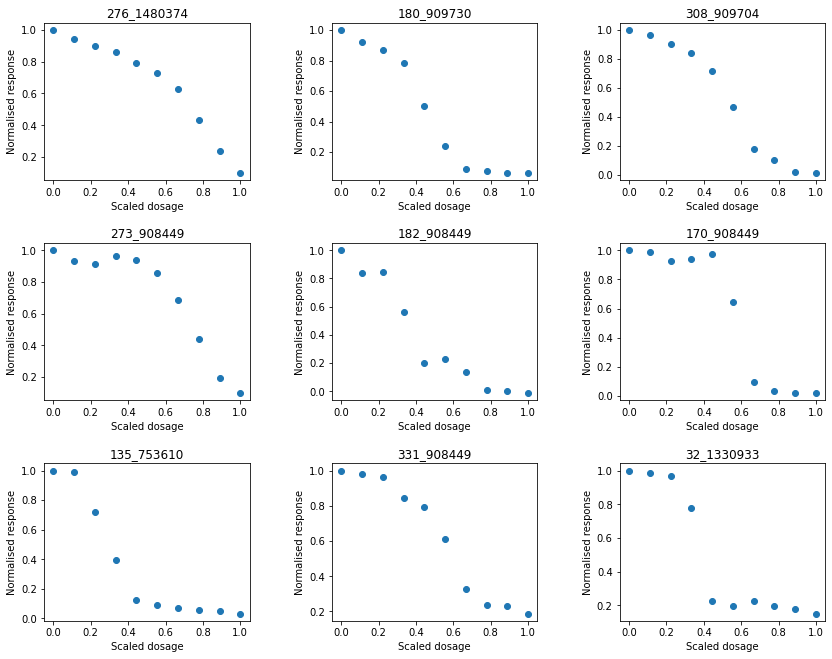

In [ ]:
new_df = df_134_02[df_134_02["sigmoid_4_param_r2"]>0.9]
ShowResponseCurves(new_df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=new_df.index[:9])


### What if don't use any filtering

In [ ]:
%%time
CompareFittingFunctions(drug_curves)

  0%|          | 133/225384 [00:00<02:49, 1325.25it/s]

(225384, 63)


 17%|█▋        | 37755/225384 [03:51<20:59, 148.92it/s]

### df_123_04 was used in the MSc project

In [13]:
df = df_123_04.copy()